# Sensitivity Analysis with the OpenCL RAMP model

### Import opencl modules

In [1]:
import numpy as np
import yaml # pyyaml library for reading the parameters.yml file
import os
import itertools

import matplotlib.pyplot as plt

from microsim.opencl.ramp.run import run_headless
from microsim.opencl.ramp.snapshot_convertor import SnapshotConvertor
from microsim.opencl.ramp.snapshot import Snapshot
from microsim.opencl.ramp.params import Params, IndividualHazardMultipliers, LocationHazardMultipliers
from microsim.opencl.ramp.simulator import Simulator
from microsim.opencl.ramp.disease_statuses import DiseaseStatus

# Useful for connecting to this kernel
%connect_info


{
  "shell_port": 9010,
  "iopub_port": 9012,
  "stdin_port": 9011,
  "control_port": 9009,
  "hb_port": 9008,
  "ip": "127.0.0.1",
  "key": "f8dbb24d-3b94-4706-9eac-6e64c873d0fc",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing /var/folders/n8/gpdfd81x2xqg81bv12th7p840000gr/T/tmp-88342a56w1tlyugAZ.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.


### Setup params for all runs

Read the parameters file

In [3]:
PARAMETERS_FILENAME = "default.yml"
with open(os.path.join("..","model_parameters", PARAMETERS_FILENAME)) as f:
    parameters = yaml.load(f, Loader=yaml.SafeLoader)
    
sim_params = parameters["microsim"]  # Parameters for the dynamic microsim (python)
calibration_params = parameters["microsim_calibration"]
disease_params = parameters["disease"]  # Parameters for the disease model (r)

Prepare the parameters for the OpenCL model. (See [main.py](https://github.com/Urban-Analytics/RAMP-UA/blob/052861cc51be5bc1827c85bb827209f0df73c685/microsim/main.py#L262) for an example of how this is done in the code). 

In [4]:
current_risk_beta = disease_params['current_risk_beta']

# The OpenCL model incorporates the current risk beta by pre-multiplying the hazard multipliers with it
location_hazard_multipliers = LocationHazardMultipliers(
    retail=calibration_params["hazard_location_multipliers"]["Retail"] * current_risk_beta,
    primary_school=calibration_params["hazard_location_multipliers"]["PrimarySchool"] * current_risk_beta,
    nightclubs=calibration_params["hazard_location_multipliers"]["Nightclubs"] * current_risk_beta,
    secondary_school=calibration_params["hazard_location_multipliers"]["SecondarySchool"] * current_risk_beta,
    home=calibration_params["hazard_location_multipliers"]["Home"] * current_risk_beta,
    work=calibration_params["hazard_location_multipliers"]["Work"] * current_risk_beta,
)

# Individual hazard multipliers can be passed straight through
individual_hazard_multipliers = IndividualHazardMultipliers(
    presymptomatic=calibration_params["hazard_individual_multipliers"]["presymptomatic"],
    asymptomatic=calibration_params["hazard_individual_multipliers"]["asymptomatic"],
    symptomatic=calibration_params["hazard_individual_multipliers"]["symptomatic"]
)

#proportion_asymptomatic = disease_params["asymp_rate"]

params = Params(
    location_hazard_multipliers=location_hazard_multipliers,
    individual_hazard_multipliers=individual_hazard_multipliers,
    #proportion_asymptomatic=proportion_asymptomatic
)

### Get snapshot path
**NB** this is the path to the OpenCL snapshot file generated by running `microsim/main.py`. You need to initilaise the model at least once to create the snapshot. The following says 'run in opencl mode and stop once initialisation has finished':

```
python microsim/main.py -ocl -init
```

In [8]:
opencl_dir = "../microsim/opencl"
snapshot_filepath = os.path.join(opencl_dir, "snapshots", "cache.npz")
snapshot_filepath

'../microsim/opencl/snapshots/cache.npz'

In [9]:
snapshot = Snapshot.load_full_snapshot(path=snapshot_filepath)
snapshot.update_params(params)
snapshot.seed_prngs(42)
data_dir = os.path.join(opencl_dir, "data")
simulator = Simulator(snapshot, opencl_dir=opencl_dir, gpu=False)

/Users/fbenitez/opt/anaconda3/envs/ramp-ua/lib/python3.7/site-packages/RAMP_UA-1.4.0.dev0-py3.7.egg/microsim/opencl/ramp/params.py:58: UserWarning: Params object is being created using hard-coded default values, not those in the parameters file.
  warnings.warn("Params object is being created using hard-coded default values, "


## Run OpenCL simulation for multiple repetitions

Code to run the simulation

In [22]:
def run_opencl_model(i, iterations, snapshot_filepath, params, opencl_dir, num_seed_days, use_gpu,
                      store_detailed_counts=True):

    # load snapshot
    snapshot = Snapshot.load_full_snapshot(path=snapshot_filepath)
    
    # set params
    snapshot.update_params(params)
    
    # set the random seed of the model for each repetition, otherwise it is completely deterministic
    snapshot.seed_prngs(i)

    # seed initial infections using GAM initial cases
    data_dir = os.path.join(opencl_dir, "data")

    # Create a simulator and upload the snapshot data to the OpenCL device
    simulator = Simulator(snapshot, opencl_dir=opencl_dir, gpu=use_gpu)
    simulator.upload_all(snapshot.buffers)
    
    print(f"Running simulation {i+1}.")
    summary, final_state = run_headless(simulator, snapshot, iterations, quiet=False,
                                        store_detailed_counts=store_detailed_counts)
    return summary, final_state


In [19]:
i=42
iterations = 120
repetitions = 5
num_seed_days = 10
use_gpu=False
sum, final = run_opencl_model(i, iterations, snapshot_filepath, params, opencl_dir, num_seed_days, use_gpu)
print(sum)

/Users/fbenitez/opt/anaconda3/envs/ramp-ua/lib/python3.7/site-packages/RAMP_UA-1.4.0.dev0-py3.7.egg/microsim/opencl/ramp/params.py:58: UserWarning: Params object is being created using hard-coded default values, not those in the parameters file.
  warnings.warn("Params object is being created using hard-coded default values, "


Running simulation 43.


Run it:

In [23]:
iterations = 120
repetitions = 5
num_seed_days = 10
use_gpu=False

summaries = []
final_results = []
# Prepare the function arguments as lists for starmap
l_i = [i for i in range(repetitions)]
l_iterations = [iterations] * repetitions
l_snapshot_filepath = [snapshot_filepath] * repetitions
l_params = [params] * repetitions
l_opencl_dir = [opencl_dir] * repetitions
l_num_seed_days = [num_seed_days] * repetitions
l_use_gpu = [use_gpu] * repetitions
results = itertools.starmap( run_opencl_model, zip(
                l_i, l_iterations, l_snapshot_filepath, l_params, l_opencl_dir, l_num_seed_days, l_use_gpu
        ))
summaries = [x[0] for x in results]
final_results = [x[1] for x in results]

/Users/fbenitez/opt/anaconda3/envs/ramp-ua/lib/python3.7/site-packages/RAMP_UA-1.4.0.dev0-py3.7.egg/microsim/opencl/ramp/params.py:58: UserWarning: Params object is being created using hard-coded default values, not those in the parameters file.
  warnings.warn("Params object is being created using hard-coded default values, "


Running simulation 1.


Running simulation: 100%|██████████| 120/120 [00:15<00:00,  7.78it/s]



Day 0
	Susceptible: 695272
	Exposed: 37
	Presymptomatic: 0
	Asymptomatic: 0
	Symptomatic: 0
	Recovered: 0
	Dead: 0

Day 1
	Susceptible: 695234
	Exposed: 69
	Presymptomatic: 1
	Asymptomatic: 5
	Symptomatic: 0
	Recovered: 0
	Dead: 0

Day 2
	Susceptible: 695194
	Exposed: 83
	Presymptomatic: 9
	Asymptomatic: 23
	Symptomatic: 0
	Recovered: 0
	Dead: 0

Day 3
	Susceptible: 695153
	Exposed: 83
	Presymptomatic: 25
	Asymptomatic: 46
	Symptomatic: 2
	Recovered: 0
	Dead: 0

Day 4
	Susceptible: 695110
	Exposed: 82
	Presymptomatic: 38
	Asymptomatic: 65
	Symptomatic: 13
	Recovered: 1
	Dead: 0

Day 5
	Susceptible: 689141
	Exposed: 6018
	Presymptomatic: 32
	Asymptomatic: 84
	Symptomatic: 32
	Recovered: 2
	Dead: 0

Day 6
	Susceptible: 683014
	Exposed: 10824
	Presymptomatic: 546
	Asymptomatic: 868
	Symptomatic: 53
	Recovered: 4
	Dead: 0

Day 7
	Susceptible: 634443
	Exposed: 54990
	Presymptomatic: 2352
	Asymptomatic: 3351
	Symptomatic: 162
	Recovered: 11
	Dead: 0

Day 8
	Susceptible: 598317
	Exposed: 757

Running simulation: 100%|██████████| 120/120 [00:15<00:00,  7.61it/s]



Day 0
	Susceptible: 695272
	Exposed: 37
	Presymptomatic: 0
	Asymptomatic: 0
	Symptomatic: 0
	Recovered: 0
	Dead: 0

Day 1
	Susceptible: 695234
	Exposed: 65
	Presymptomatic: 5
	Asymptomatic: 5
	Symptomatic: 0
	Recovered: 0
	Dead: 0

Day 2
	Susceptible: 695194
	Exposed: 86
	Presymptomatic: 11
	Asymptomatic: 18
	Symptomatic: 0
	Recovered: 0
	Dead: 0

Day 3
	Susceptible: 695153
	Exposed: 83
	Presymptomatic: 25
	Asymptomatic: 41
	Symptomatic: 7
	Recovered: 0
	Dead: 0

Day 4
	Susceptible: 695110
	Exposed: 86
	Presymptomatic: 31
	Asymptomatic: 65
	Symptomatic: 17
	Recovered: 0
	Dead: 0

Day 5
	Susceptible: 691295
	Exposed: 3867
	Presymptomatic: 30
	Asymptomatic: 84
	Symptomatic: 33
	Recovered: 0
	Dead: 0

Day 6
	Susceptible: 687125
	Exposed: 7142
	Presymptomatic: 436
	Asymptomatic: 553
	Symptomatic: 52
	Recovered: 1
	Dead: 0

Day 7
	Susceptible: 640410
	Exposed: 50963
	Presymptomatic: 1768
	Asymptomatic: 2028
	Symptomatic: 136
	Recovered: 4
	Dead: 0

Day 8
	Susceptible: 599801
	Exposed: 7811

Running simulation: 100%|██████████| 120/120 [00:15<00:00,  7.73it/s]



Day 0
	Susceptible: 695272
	Exposed: 37
	Presymptomatic: 0
	Asymptomatic: 0
	Symptomatic: 0
	Recovered: 0
	Dead: 0

Day 1
	Susceptible: 695234
	Exposed: 67
	Presymptomatic: 3
	Asymptomatic: 5
	Symptomatic: 0
	Recovered: 0
	Dead: 0

Day 2
	Susceptible: 695194
	Exposed: 82
	Presymptomatic: 16
	Asymptomatic: 17
	Symptomatic: 0
	Recovered: 0
	Dead: 0

Day 3
	Susceptible: 695153
	Exposed: 83
	Presymptomatic: 32
	Asymptomatic: 36
	Symptomatic: 5
	Recovered: 0
	Dead: 0

Day 4
	Susceptible: 695110
	Exposed: 85
	Presymptomatic: 33
	Asymptomatic: 60
	Symptomatic: 21
	Recovered: 0
	Dead: 0

Day 5
	Susceptible: 691263
	Exposed: 3891
	Presymptomatic: 29
	Asymptomatic: 86
	Symptomatic: 40
	Recovered: 0
	Dead: 0

Day 6
	Susceptible: 686374
	Exposed: 7879
	Presymptomatic: 453
	Asymptomatic: 541
	Symptomatic: 60
	Recovered: 2
	Dead: 0

Day 7
	Susceptible: 639350
	Exposed: 51884
	Presymptomatic: 1786
	Asymptomatic: 2122
	Symptomatic: 160
	Recovered: 7
	Dead: 0

Day 8
	Susceptible: 601219
	Exposed: 7615

Running simulation: 100%|██████████| 120/120 [00:15<00:00,  7.57it/s]



Day 0
	Susceptible: 695272
	Exposed: 37
	Presymptomatic: 0
	Asymptomatic: 0
	Symptomatic: 0
	Recovered: 0
	Dead: 0

Day 1
	Susceptible: 695234
	Exposed: 70
	Presymptomatic: 2
	Asymptomatic: 3
	Symptomatic: 0
	Recovered: 0
	Dead: 0

Day 2
	Susceptible: 695194
	Exposed: 84
	Presymptomatic: 13
	Asymptomatic: 17
	Symptomatic: 1
	Recovered: 0
	Dead: 0

Day 3
	Susceptible: 695153
	Exposed: 87
	Presymptomatic: 28
	Asymptomatic: 37
	Symptomatic: 4
	Recovered: 0
	Dead: 0

Day 4
	Susceptible: 695110
	Exposed: 90
	Presymptomatic: 35
	Asymptomatic: 57
	Symptomatic: 16
	Recovered: 1
	Dead: 0

Day 5
	Susceptible: 690470
	Exposed: 4683
	Presymptomatic: 35
	Asymptomatic: 84
	Symptomatic: 35
	Recovered: 2
	Dead: 0

Day 6
	Susceptible: 684687
	Exposed: 9347
	Presymptomatic: 589
	Asymptomatic: 627
	Symptomatic: 54
	Recovered: 5
	Dead: 0

Day 7
	Susceptible: 634727
	Exposed: 55750
	Presymptomatic: 2237
	Asymptomatic: 2415
	Symptomatic: 173
	Recovered: 7
	Dead: 0

Day 8
	Susceptible: 597480
	Exposed: 7767

Running simulation: 100%|██████████| 120/120 [00:15<00:00,  7.75it/s]



Day 0
	Susceptible: 695272
	Exposed: 37
	Presymptomatic: 0
	Asymptomatic: 0
	Symptomatic: 0
	Recovered: 0
	Dead: 0

Day 1
	Susceptible: 695234
	Exposed: 64
	Presymptomatic: 4
	Asymptomatic: 7
	Symptomatic: 0
	Recovered: 0
	Dead: 0

Day 2
	Susceptible: 695194
	Exposed: 76
	Presymptomatic: 16
	Asymptomatic: 22
	Symptomatic: 1
	Recovered: 0
	Dead: 0

Day 3
	Susceptible: 695153
	Exposed: 79
	Presymptomatic: 32
	Asymptomatic: 41
	Symptomatic: 4
	Recovered: 0
	Dead: 0

Day 4
	Susceptible: 695110
	Exposed: 84
	Presymptomatic: 31
	Asymptomatic: 62
	Symptomatic: 22
	Recovered: 0
	Dead: 0

Day 5
	Susceptible: 691016
	Exposed: 4143
	Presymptomatic: 27
	Asymptomatic: 84
	Symptomatic: 38
	Recovered: 1
	Dead: 0

Day 6
	Susceptible: 686324
	Exposed: 7888
	Presymptomatic: 442
	Asymptomatic: 593
	Symptomatic: 57
	Recovered: 5
	Dead: 0

Day 7
	Susceptible: 638732
	Exposed: 52428
	Presymptomatic: 1754
	Asymptomatic: 2231
	Symptomatic: 152
	Recovered: 12
	Dead: 0

Day 8
	Susceptible: 601484
	Exposed: 756

## Plot output summary data

### Total counts of disease status

In [25]:
def plot_summaries(summaries, plot_type="error_bars"):

    #fig, ax = plt.subplots(1, len(DiseaseStatus), sharey=True)
    fig, ax = plt.subplots(1, 1, figsize=(10,7))
    
    # Work out the number of repetitions and iterations
    iters, reps = _get_iters_and_reps(summaries)
    x = range(iters)

    for d, disease_status in enumerate(DiseaseStatus):
        if disease_status==DiseaseStatus.Susceptible or disease_status==DiseaseStatus.Recovered:
            continue
        # Calculate the mean and standard deviation
        matrix = np.zeros(shape=(reps,iters))
        for rep in range(reps):
            matrix[rep] = summaries[rep].total_counts[d]
        mean = np.mean(matrix, axis=0)
        sd = np.std(matrix, axis=0)
        if plot_type == "error_bars":
            ax.errorbar(x, mean, sd, label=f"{disease_status}" )
        elif plot_type == "lines":
            for rep in range(reps):
                ax.plot(x, matrix[rep], label=f"{disease_status} {rep}", 
                        color=plt.cm.get_cmap("hsv", len(DiseaseStatus))(d) )
                
    ax.legend() 
    ax.set_title("Disease Status")
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Number of cases")

def _get_iters_and_reps(summaries):
    reps = len(summaries)
    iters = len(summaries[0].total_counts[0])
    return (iters, reps)

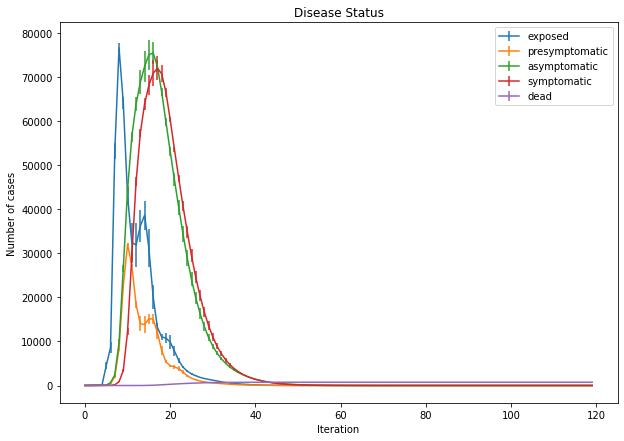

In [27]:
plot_summaries(summaries=summaries, plot_type="error_bars")

In [ ]:
#plot_summaries(summaries=summaries, plot_type="lines")

### Disease statuses by age

In [28]:
   
def plot_disease_status_by_age(summaries):

    #fig, ax = plt.subplots(1, len(DiseaseStatus), sharey=True)
    fig, ax = plt.subplots(int(len(DiseaseStatus)/2), int(len(DiseaseStatus)/2), 
                           figsize=(15,11), tight_layout=True)
    iters, reps = _get_iters_and_reps(summaries)
    x = range(iters)
    age_thresholds = summaries[0].age_thresholds

    for d, disease_status in enumerate(DiseaseStatus):
        lower_age_bound = 0
        for age_idx in range(len(age_thresholds)):
            matrix = np.zeros(shape=(reps, iters))
            for rep in range(reps):
                #matrix[age_idx][rep][it] = summaries[rep].age_counts[str(disease_status)][age_idx][it]
                matrix[rep] = summaries[rep].age_counts[str(disease_status)][age_idx]
            mean = np.mean(matrix, axis=0)
            sd = np.std(matrix, axis=0)
            ax.flat[d].errorbar(x, mean, sd, label=f"{lower_age_bound} - {age_thresholds[age_idx]}" )
            lower_age_bound = age_thresholds[age_idx]
                
            ax.flat[d].legend() 
            ax.flat[d].set_title(f"{str(disease_status)}")
            ax.flat[d].set_xlabel("Iteration")
            ax.flat[d].set_ylabel("Number of cases")
    #fig.set_title(f"Num {disease_status} people by age group")

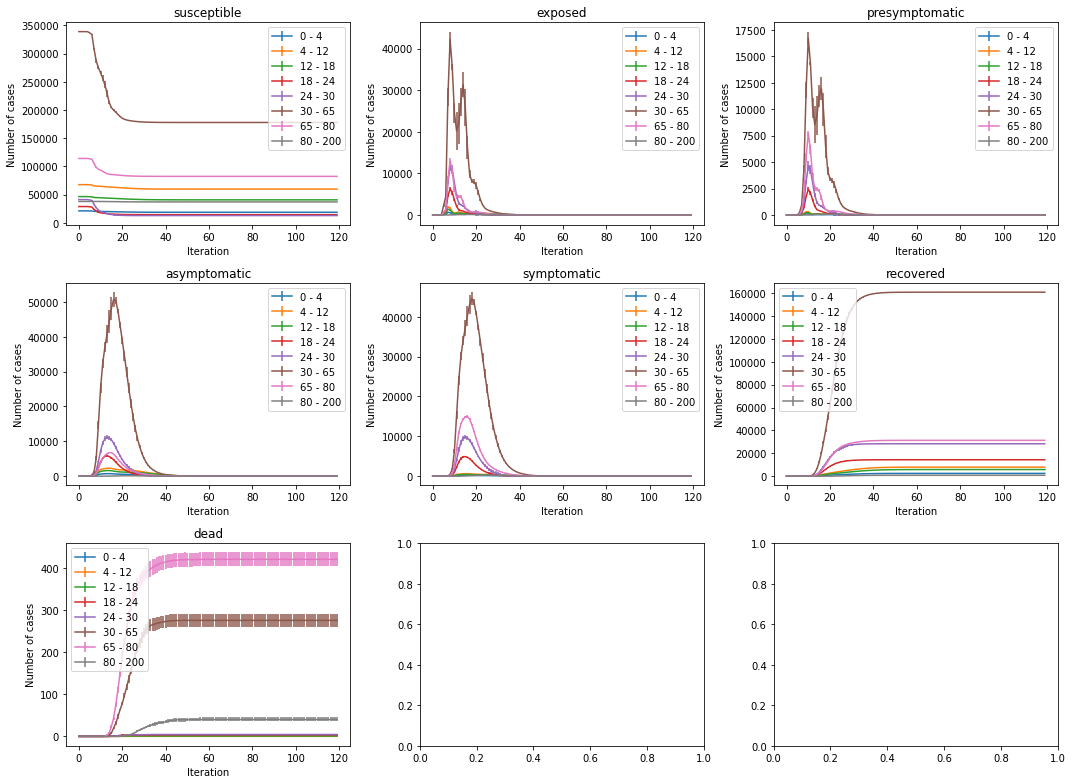

In [29]:
plot_disease_status_by_age(summaries)

### Plot MSOA geodata

#### Load MSOA shapes

Loading OSM buildings shapefile
Loaded 206583 buildings from shapefile
Loaded 7201 MSOA shapes with projection epsg:27700
Loaded 107 devon MSOA codes
Filtered 107 devon MSOA shapes


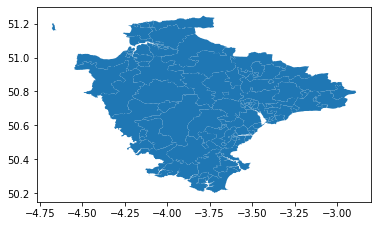

In [30]:
from microsim.load_msoa_locations import load_osm_shapefile, load_msoa_shapes
import pandas as pd

data_dir = ("../devon_data")

osm_buildings = load_osm_shapefile(data_dir)

devon_msoa_shapes = load_msoa_shapes(data_dir, visualize=False)

devon_msoa_shapes.plot()
plt.show()

In [31]:
import pandas as pd

def plot_msoa_choropleth(msoa_shapes, summary, disease_status, timestep):
    # get dataframes for all statuses
    msoa_data = summary.get_area_dataframes()
    
    msoa_data_for_status = msoa_data[disease_status]

    # add "Code" column so dataframes can be merged
    msoa_data_for_status["Code"] = msoa_data_for_status.index
    msoa_shapes = pd.merge(msoa_shapes, msoa_data_for_status, on="Code")

    msoa_shapes.plot(column=f"Day{timestep}", legend=True)
    plt.show()

### Plot disease status by MSOA for a given timestep and status